# Proyek Akhir: Menyelesaikan Permasalahan Institusi Pendidikan

- Nama: Patuh Rujhan Al Istizhar
- Email: patuh41@gmail.com
- ID Dicoding: patuh_istizhar

## Persiapan

### Menyiapkan library yang dibutuhkan

In [1]:
# Data Handling & Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing & Modeling
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Models
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Metrics
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    roc_curve,
)

# Hyperparameter Optimization
import optuna

# Utilities
import joblib
import warnings
import os
from collections import Counter

# --- Settings ---
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.style.use("seaborn-v0_8-whitegrid")
sns.set_palette("viridis")

# --- Constants ---
RANDOM_STATE = 42
TEST_SIZE = 0.2
CV_FOLDS = 5
FILE_PATH = "data/data.csv"
MODEL_DIR = "models"
TARGET_COLUMN_ORIGINAL = "Status"
TARGET_COLUMN_BINARY = "Is_Dropout"

os.makedirs(MODEL_DIR, exist_ok=True)

### Menyiapkan data yang akan digunakan

In [2]:
# Muat dataset
df_raw = pd.read_csv(FILE_PATH, sep=";")
print(f"Data berhasil dimuat dari '{FILE_PATH}'.")
print("Shape data:", df_raw.shape)
print("\nPreview data (5 baris pertama):")
display(df_raw.head())

Data berhasil dimuat dari 'data/data.csv'.
Shape data: (4424, 37)

Preview data (5 baris pertama):


,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,Mothers_occupation,Fathers_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_credited,Curricular_units_1st_sem_enrolled,Curricular_units_1st_sem_evaluations,Curricular_units_1st_sem_approved,Curricular_units_1st_sem_grade,Curricular_units_1st_sem_without_evaluations,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
0,1,17,5,171,1,1,122.0,1,19,12,5,9,127.3,1,0,0,1,1,0,20,0,0,0,0,0,0.000000,0,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,3,3,142.5,1,0,0,0,1,0,19,0,0,6,6,6,14.000000,0,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,9,9,124.8,1,0,0,0,1,0,19,0,0,6,0,0,0.000000,0,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,5,3,119.6,1,0,0,1,0,0,20,0,0,6,8,6,13.428571,0,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,9,9,141.5,0,0,0,1,0,0,45,0,0,6,9,5,12.333333,0,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


## Data Understanding

Tahap ini bertujuan untuk memahami struktur data, tipe data, statistik deskriptif, dan mengidentifikasi potensi masalah seperti missing values, outlier, atau ketidaksesuaian data. Fokus utama adalah memahami variabel target (`Status`) dan hubungan awalnya dengan fitur-fitur lain, serta memahami arti dari nilai-nilai yang terkode pada beberapa kolom. Ini akan membantu menjawab masalah bisnis pertama: **Identifikasi Faktor Penyebab Dropout**.

#### Informasi Dasar, Missing Values, dan Duplikat

In [3]:
print("Dataset Info:")
df_raw.info()

print("\nStatistik Deskriptif (Termasuk Kolom Kategorikal):")
display(df_raw.describe(include="all"))

print("\nMissing Values per Column (jika ada):")
missing_values = df_raw.isnull().sum()
print(missing_values[missing_values > 0])

print(f"\nJumlah duplikat: {df_raw.duplicated().sum()}")

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Marital_status                                4424 non-null   int64  
 1   Application_mode                              4424 non-null   int64  
 2   Application_order                             4424 non-null   int64  
 3   Course                                        4424 non-null   int64  
 4   Daytime_evening_attendance                    4424 non-null   int64  
 5   Previous_qualification                        4424 non-null   int64  
 6   Previous_qualification_grade                  4424 non-null   float64
 7   Nacionality                                   4424 non-null   int64  
 8   Mothers_qualification                         4424 non-null   int64  
 9   Fathers_qualification                         442

,Marital_status,Application_mode,Application_order,Course,Daytime_evening_attendance,Previous_qualification,Previous_qualification_grade,Nacionality,Mothers_qualification,Fathers_qualification,Mothers_occupation,Fathers_occupation,Admission_grade,Displaced,Educational_special_needs,Debtor,Tuition_fees_up_to_date,Gender,Scholarship_holder,Age_at_enrollment,International,Curricular_units_1st_sem_credited,Curricular_units_1st_sem_enrolled,Curricular_units_1st_sem_evaluations,Curricular_units_1st_sem_approved,Curricular_units_1st_sem_grade,Curricular_units_1st_sem_without_evaluations,Curricular_units_2nd_sem_credited,Curricular_units_2nd_sem_enrolled,Curricular_units_2nd_sem_evaluations,Curricular_units_2nd_sem_approved,Curricular_units_2nd_sem_grade,Curricular_units_2nd_sem_without_evaluations,Unemployment_rate,Inflation_rate,GDP,Status
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Graduate
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2209
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,10.960895,11.032324,126.978119,0.548373,0.011528,0.113698,0.880651,0.351718,0.248418,23.265145,0.024864,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,NaN
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,26.418253,25.263040,14.482001,0.497711,0.106760,0.317480,0.324235,0.477560,0.432144,7.587816,0.155729,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,NaN
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,0.000000,0.000000,95.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,NaN
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,4.000000,4.000000,117.900000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,19.000000,0.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,NaN
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,5.000000,7.000000,126.100000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,20.000000,0.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,NaN
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,9.000000,9.000000,134.800000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,25.000000,0.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,NaN



Missing Values per Column (jika ada):
Series([], dtype: int64)

Jumlah duplikat: 0


#### Distribusi Variabel Target (`Status`)

Distribusi Variabel Target ('Status'):
Status
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64

Persentase Distribusi:
Graduate: 49.93%
Dropout: 32.12%
Enrolled: 17.95%


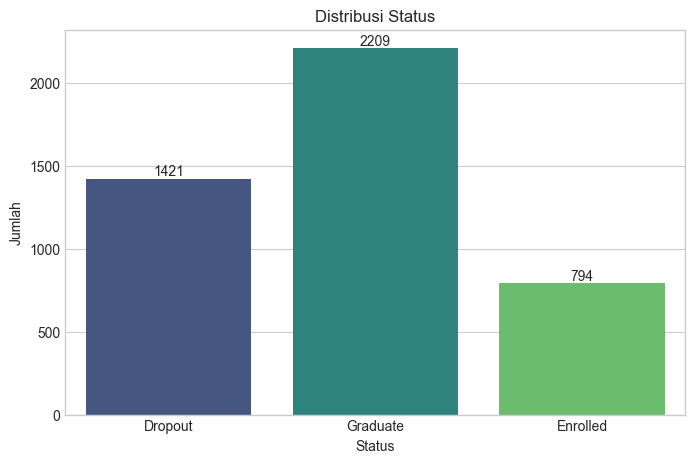

In [4]:
print(f"Distribusi Variabel Target ('{TARGET_COLUMN_ORIGINAL}'):")
print(df_raw[TARGET_COLUMN_ORIGINAL].value_counts())
print("\nPersentase Distribusi:")
percentage_distribution = (
    df_raw[TARGET_COLUMN_ORIGINAL].value_counts(normalize=True) * 100
)
for status_val, percentage in percentage_distribution.items():
    print(f"{status_val}: {percentage:.2f}%")

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    x=TARGET_COLUMN_ORIGINAL,
    data=df_raw,
    hue=TARGET_COLUMN_ORIGINAL,
    palette="viridis",
    legend=False,
)
plt.title(f"Distribusi {TARGET_COLUMN_ORIGINAL}")
plt.xlabel(TARGET_COLUMN_ORIGINAL)
plt.ylabel("Jumlah")
for container in ax.containers:
    ax.bar_label(container, fmt="%d")
plt.show()

### Interpretasi Distribusi Status Siswa

Distribusi kelas target menunjukkan ketidakseimbangan:
- **Graduate:** 2209 (49.93%)
- **Dropout:** 1421 (32.12%)
- **Enrolled:** 794 (17.95%)

Untuk model prediksi dropout biner, kelas 'Dropout' akan menjadi kelas positif kita. Implikasi dari ketidakseimbangan ini adalah model mungkin cenderung lebih baik dalam memprediksi kelas mayoritas (Graduate/Enrolled jika digabung) jika tidak ditangani dengan baik. Oleh karena itu, metrik seperti Recall dan F1-score untuk kelas 'Dropout', serta ROC AUC, akan lebih penting daripada akurasi keseluruhan. Teknik penanganan imbalance seperti `class_weight` pada model atau `scale_pos_weight` (untuk XGBoost/LightGBM) akan dipertimbangkan.

#### Identifikasi Tipe Fitur & Eksplorasi Fitur Numerik vs Status


Fitur Numerik Aktual untuk EDA (18):['Previous_qualification_grade', 'Admission_grade', 'Age_at_enrollment', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP']

Fitur Kategorikal Aktual untuk EDA (18):['Status', 'Marital_status', 'Application_mode', 'Course', 'Daytime_evening_attendance', 'Previous_qualification', 'Nacionality', 'Mothers_qualification', 'Fathers_qualification', 'Mothers_occupation', 'Fathers_occupation', 'Displaced', 'Educational_special_needs', 'Debtor', 'Tuition_fees_up_to_date', 'Gender', 'Scholarship_holder', 'I

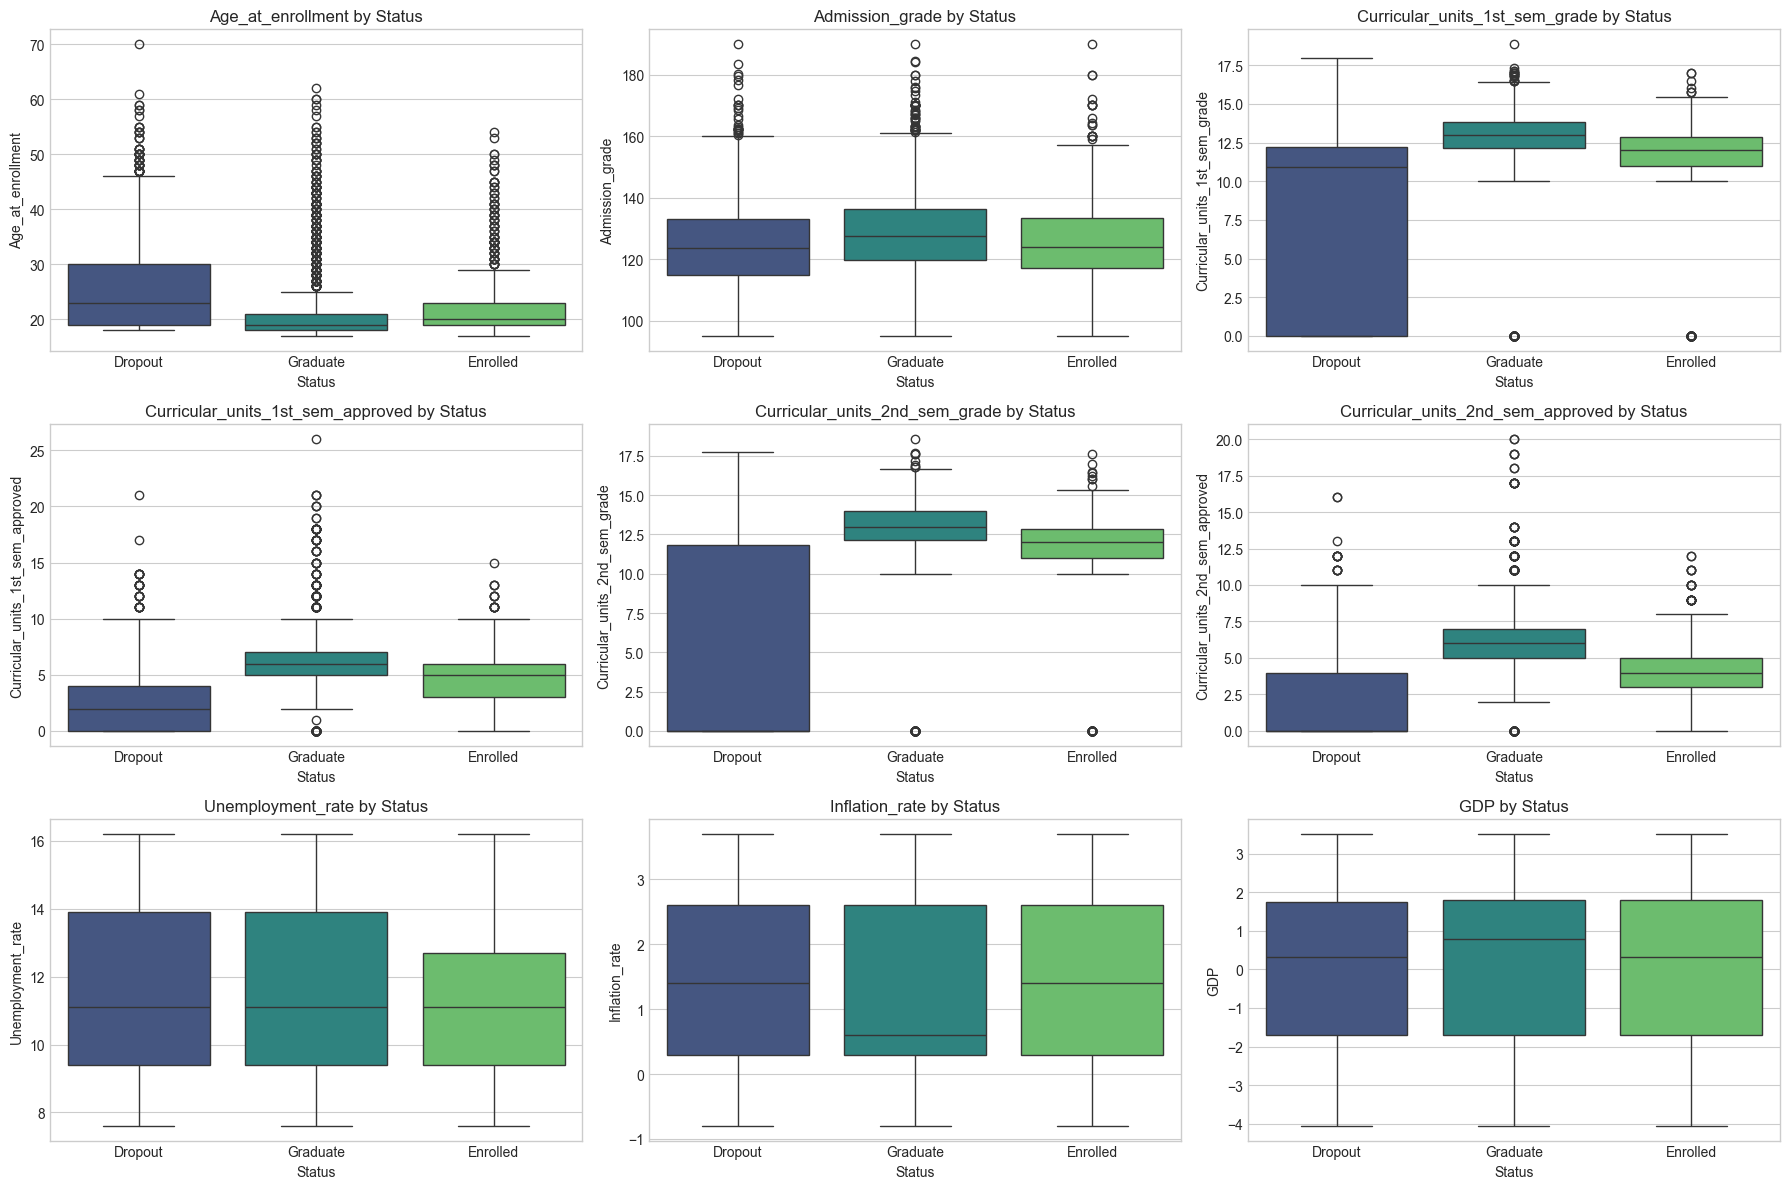

In [5]:
# Kolom yang terkode numerik tapi sebenarnya kategorikal (dari deskripsi dataset)
list_kolom_kategorikal_numeric = [
    "Marital_status",
    "Application_mode",
    "Course",
    "Daytime_evening_attendance",
    "Previous_qualification",
    "Nacionality",
    "Mothers_qualification",
    "Fathers_qualification",
    "Mothers_occupation",
    "Fathers_occupation",
    "Educational_special_needs",
    "Debtor",
    "Tuition_fees_up_to_date",
    "Gender",
    "Scholarship_holder",
    "International",
    "Displaced",
]

initial_numerical_features = df_raw.select_dtypes(include=np.number).columns.tolist()
initial_categorical_features = df_raw.select_dtypes(include="object").columns.tolist()

final_numerical_features_eda = []
final_categorical_features_eda = list(initial_categorical_features)

for col in initial_numerical_features:
    if col in list_kolom_kategorikal_numeric:
        final_categorical_features_eda.append(col)
    elif col != TARGET_COLUMN_ORIGINAL and col != "Application_order":
        final_numerical_features_eda.append(col)

print(
    f"\nFitur Numerik Aktual untuk EDA ({len(final_numerical_features_eda)}):{final_numerical_features_eda}"
)
print(
    f"\nFitur Kategorikal Aktual untuk EDA ({len(final_categorical_features_eda)}):{final_categorical_features_eda}"
)

print("\n--- Eksplorasi Fitur Numerik vs Status ---")
numeric_to_plot = [
    "Age_at_enrollment",
    "Admission_grade",
    "Curricular_units_1st_sem_grade",
    "Curricular_units_1st_sem_approved",
    "Curricular_units_2nd_sem_grade",
    "Curricular_units_2nd_sem_approved",
    "Unemployment_rate",
    "Inflation_rate",
    "GDP",
]
numeric_to_plot_exist = [
    col for col in numeric_to_plot if col in final_numerical_features_eda
]

if numeric_to_plot_exist:
    n_cols_viz = 3
    n_rows_viz = (len(numeric_to_plot_exist) + n_cols_viz - 1) // n_cols_viz
    fig, axes = plt.subplots(
        n_rows_viz, n_cols_viz, figsize=(n_cols_viz * 6, n_rows_viz * 4)
    )
    axes = axes.flatten()
    for i, col in enumerate(numeric_to_plot_exist):
        sns.boxplot(
            x=TARGET_COLUMN_ORIGINAL,
            y=col,
            data=df_raw,
            hue=TARGET_COLUMN_ORIGINAL,
            palette="viridis",
            ax=axes[i],
            legend=False,
        )
        axes[i].set_title(f"{col} by {TARGET_COLUMN_ORIGINAL}")
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()


### Interpretasi Hubungan Variabel Numerik dengan Status Siswa

- **Usia saat Pendaftaran (`Age_at_enrollment`):** Mahasiswa yang *dropout* cenderung memiliki usia yang sedikit lebih tua dibandingkan yang *graduate* atau *enrolled*.
- **Nilai Akademik (Semester 1 & 2, Nilai Penerimaan):** Mahasiswa yang *dropout* secara konsisten menunjukkan nilai rata-rata yang lebih rendah pada `Admission_grade`, `Curricular_units_1st_sem_grade`, dan `Curricular_units_2nd_sem_grade` dibandingkan dengan yang *graduate*. Jumlah unit yang disetujui (`approved`) juga lebih rendah untuk kelompok *dropout*.
- **Faktor Ekonomi Makro (`Unemployment_rate`, `Inflation_rate`, `GDP`):** Perbedaan distribusi pada fitur ini antar status mahasiswa tidak terlalu mencolok dari boxplot, mungkin memerlukan analisis lebih lanjut atau tidak menjadi pembeda utama secara langsung.

Insight ini menunjukkan bahwa performa akademik awal dan jumlah unit yang berhasil diselesaikan adalah indikator kuat. Usia juga bisa menjadi faktor. Informasi ini penting untuk dashboard (Masalah 2) sebagai *early warning indicators* dan identifikasi faktor risiko (Masalah 1).

#### Eksplorasi Fitur Kategorikal vs Status

--- Eksplorasi Fitur Kategorikal vs Status ---


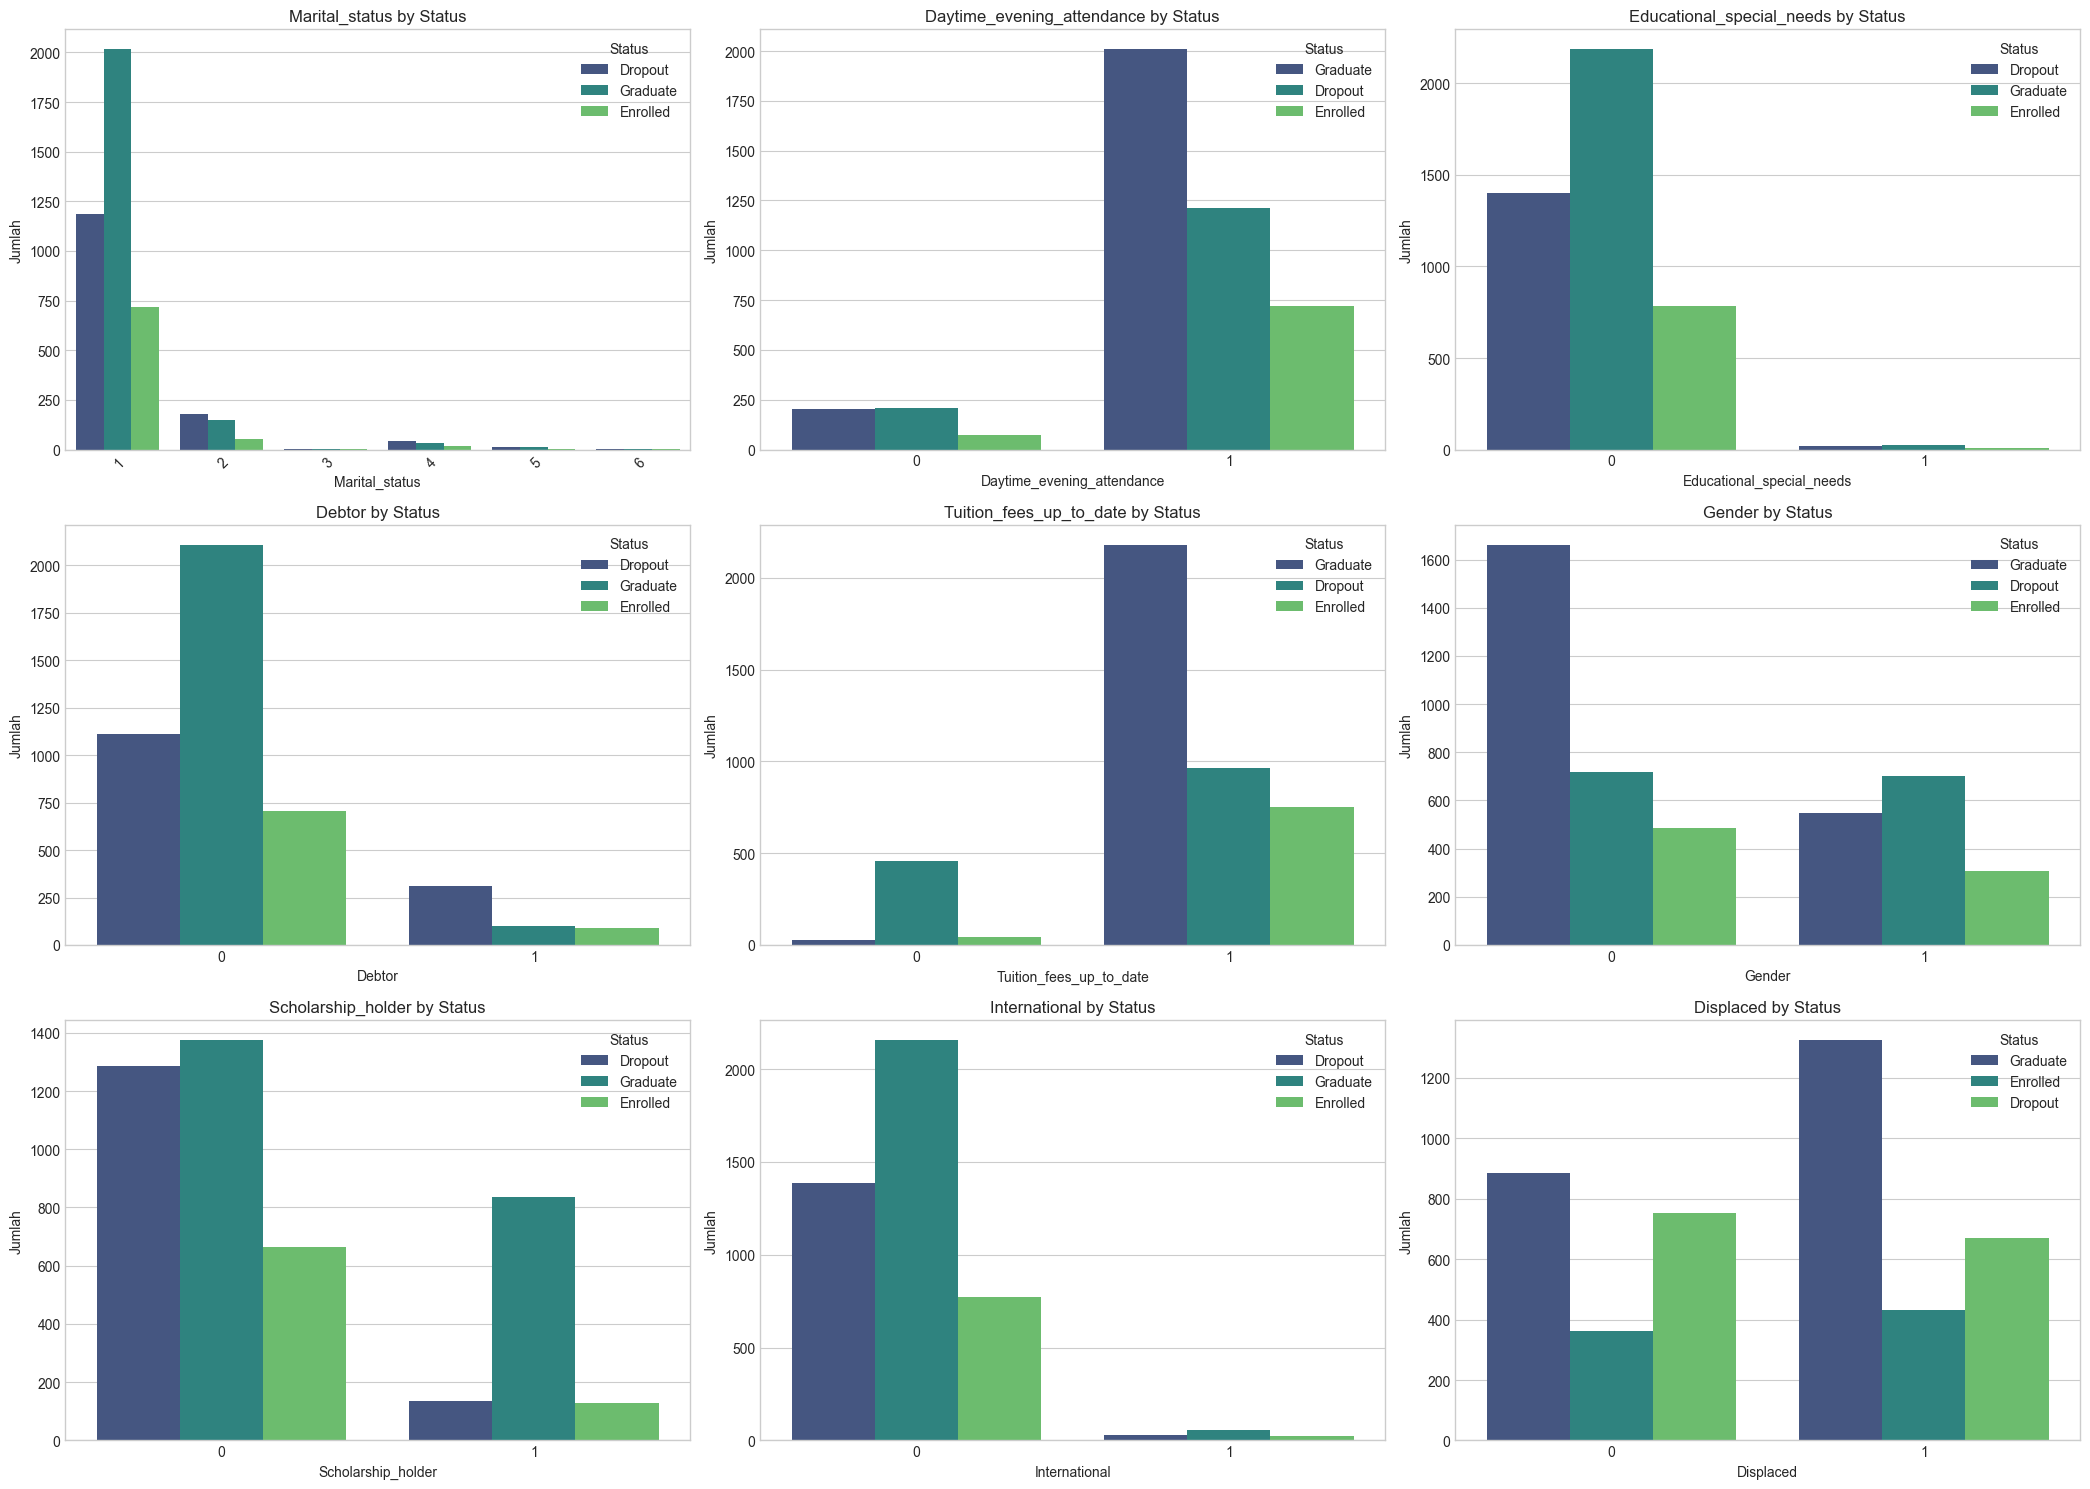

In [6]:
print("--- Eksplorasi Fitur Kategorikal vs Status ---")
categorical_to_plot = [
    "Marital_status",
    "Daytime_evening_attendance",
    "Educational_special_needs",
    "Debtor",
    "Tuition_fees_up_to_date",
    "Gender",
    "Scholarship_holder",
    "International",
    "Displaced",
]
categorical_to_plot_exist = [
    col
    for col in categorical_to_plot
    if col in final_categorical_features_eda and col in df_raw.columns
]

if categorical_to_plot_exist:
    n_cols_cat_viz = 3
    n_rows_cat_viz = (
        len(categorical_to_plot_exist) + n_cols_cat_viz - 1
    ) // n_cols_cat_viz
    fig, axes = plt.subplots(
        n_rows_cat_viz, n_cols_cat_viz, figsize=(n_cols_cat_viz * 7, n_rows_cat_viz * 5)
    )
    axes = axes.flatten()
    for i, col in enumerate(categorical_to_plot_exist):
        sns.countplot(
            data=df_raw,
            x=col,
            hue=TARGET_COLUMN_ORIGINAL,
            palette="viridis",
            ax=axes[i],
        )
        axes[i].set_title(f"{col} by {TARGET_COLUMN_ORIGINAL}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Jumlah")
        if df_raw[col].nunique() > 5:
            axes[i].tick_params(axis="x", rotation=45)
            plt.setp(axes[i].get_xticklabels(), ha="right", rotation_mode="anchor")
        else:
            axes[i].tick_params(axis="x", rotation=0)
            plt.setp(axes[i].get_xticklabels(), ha="center")
        axes[i].legend(title=TARGET_COLUMN_ORIGINAL)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

### Interpretasi Hubungan Variabel Kategorikal dengan Status Siswa

- **Status Pembayaran (`Tuition_fees_up_to_date`):** Mahasiswa yang biaya kuliahnya tidak *up-to-date* (nilai 0) memiliki proporsi *dropout* yang sangat tinggi dibandingkan yang *up-to-date* (nilai 1).
- **Debitur (`Debtor`):** Serupa dengan status pembayaran, mahasiswa yang merupakan debitur (nilai 1) menunjukkan tingkat *dropout* yang lebih tinggi.
- **Beasiswa (`Scholarship_holder`):** Mahasiswa penerima beasiswa (nilai 1) memiliki proporsi *dropout* yang relatif lebih rendah dibandingkan yang tidak menerima beasiswa (nilai 0).
- **Kehadiran (`Daytime_evening_attendance`):** Perlu dilihat lebih detail proporsinya, namun secara visual, distribusi status agak berbeda antara mahasiswa siang (1) dan malam (0).
- **Status Pernikahan (`Marital_status`), Jenis Kelamin (`Gender`), dll.:** Perlu analisis proporsi yang lebih detail, namun beberapa kategori mungkin menunjukkan kecenderungan *dropout* yang berbeda.

Fitur finansial (`Tuition_fees_up_to_date`, `Debtor`) dan dukungan (`Scholarship_holder`) tampaknya menjadi faktor signifikan yang terkait dengan *dropout*.

#### Matriks Korelasi Antar Fitur Numerik


--- Korelasi Antar Fitur Numerik ---


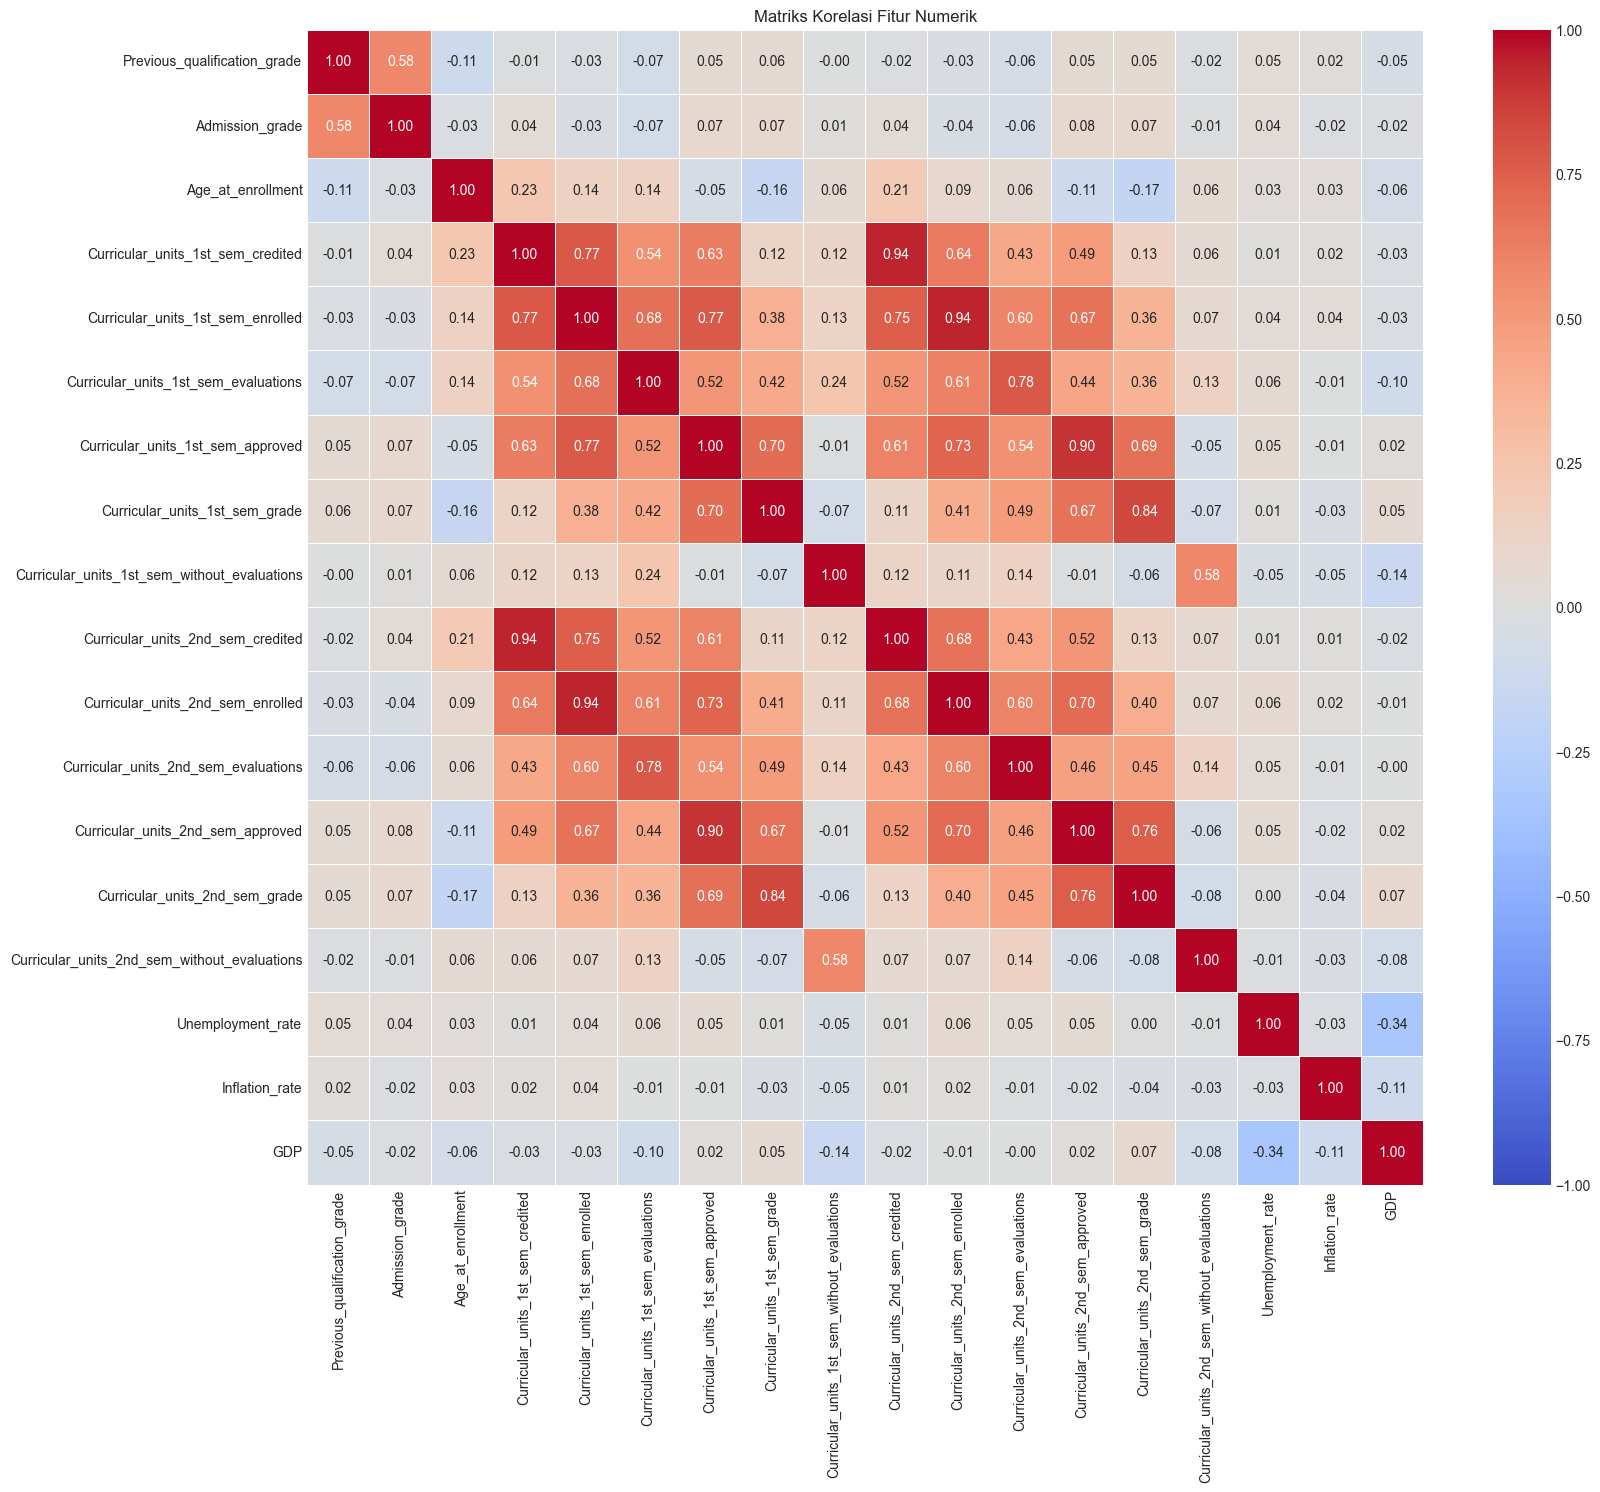

In [7]:
print("\n--- Korelasi Antar Fitur Numerik ---")
if len(final_numerical_features_eda) > 1:
    correlation_matrix = df_raw[final_numerical_features_eda].corr()
    plt.figure(figsize=(18, 15))
    sns.heatmap(
        correlation_matrix,
        annot=True,
        cmap="coolwarm",
        fmt=".2f",
        linewidths=0.5,
        vmin=-1,
        vmax=1,
    )
    plt.title("Matriks Korelasi Fitur Numerik")
    plt.show()

### Interpretasi Korelasi Antar Fitur Numerik

- Terdapat korelasi positif yang cukup kuat antara jumlah unit yang diambil, unit yang lulus, dan nilai pada semester 1 dan semester 2. Misalnya, `Curricular_units_1st_sem_approved` berkorelasi positif dengan `Curricular_units_1st_sem_grade` dan juga dengan `Curricular_units_2nd_sem_approved`.
- `Admission_grade` juga menunjukkan korelasi positif dengan nilai-nilai dan unit yang disetujui di semester berikutnya.
- Fitur ekonomi makro (`Unemployment_rate`, `Inflation_rate`, `GDP`) memiliki korelasi yang relatif rendah dengan fitur-fitur akademik mahasiswa.

Implikasi: Korelasi tinggi antar fitur akademik (misal, antara nilai dan unit yang disetujui) adalah hal yang wajar. Untuk model linear, ini bisa menjadi perhatian (multikolinearitas), tetapi untuk model berbasis pohon (Random Forest, XGBoost, LightGBM) dampaknya umumnya lebih kecil.

#### Pengecekan Outlier

--- Pengecekan Outlier Sederhana ---


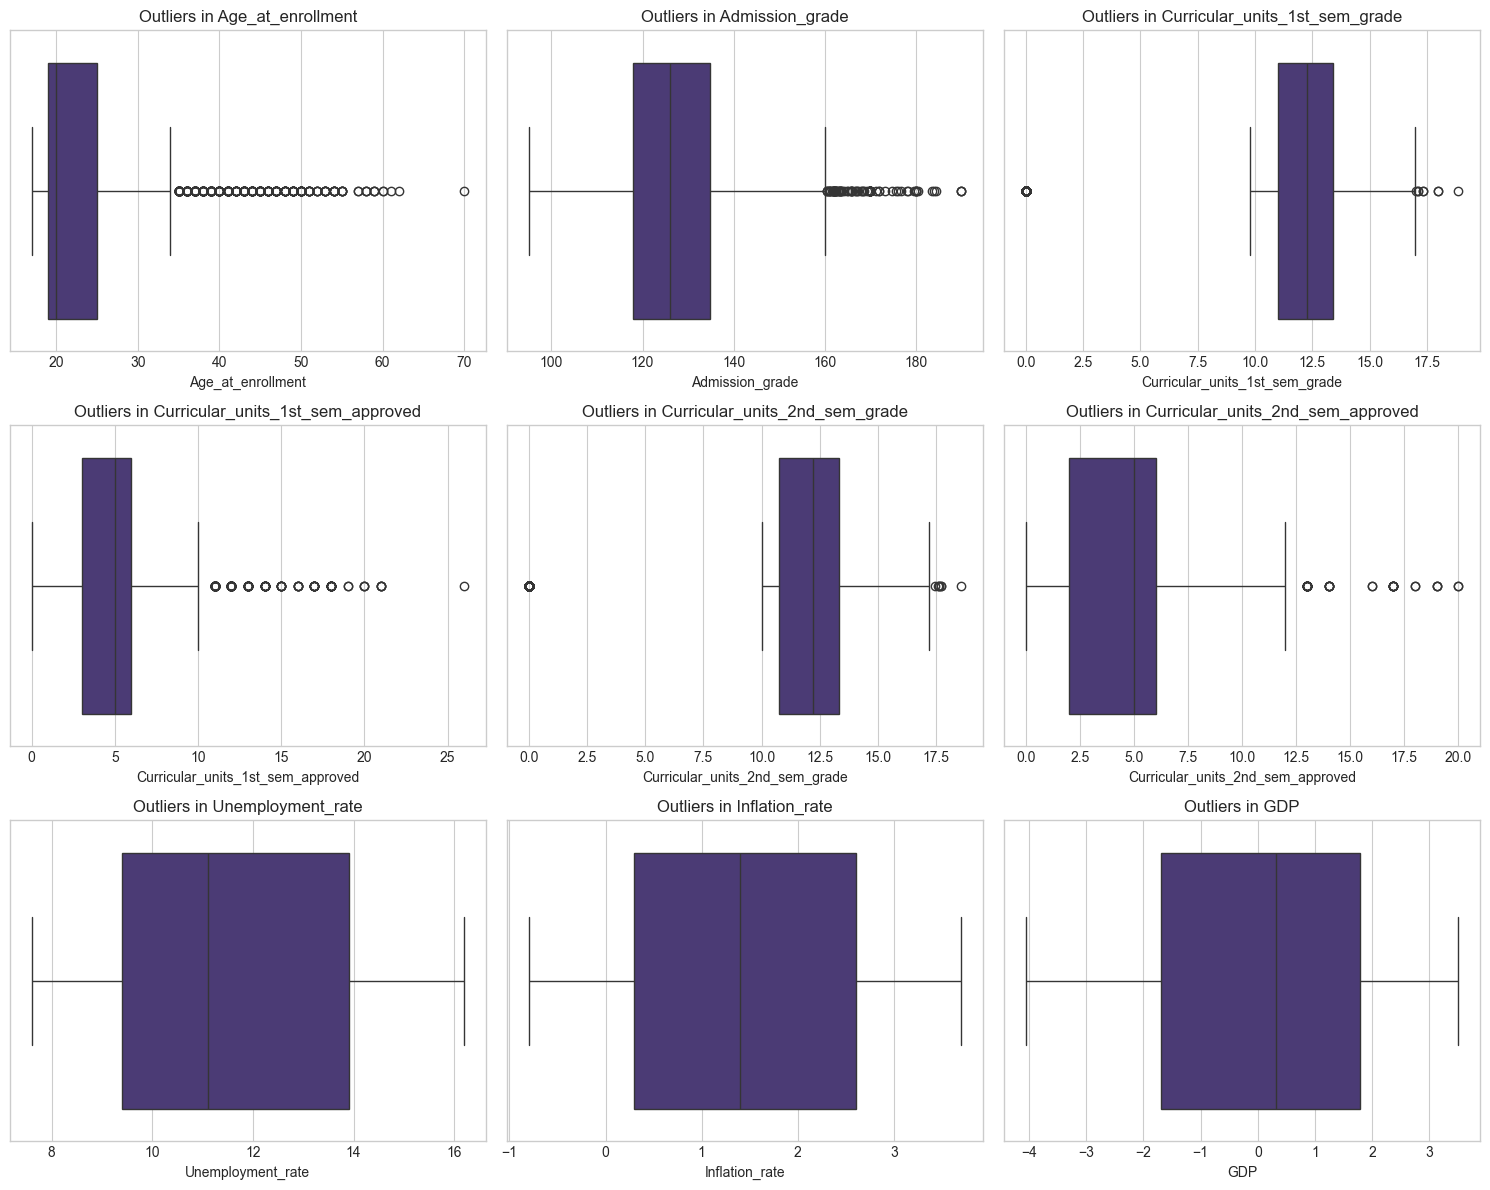

In [8]:
print("--- Pengecekan Outlier Sederhana ---")
if "numeric_to_plot_exist" in locals() and numeric_to_plot_exist:
    n_cols_out_viz = 3
    n_rows_out_viz = (len(numeric_to_plot_exist) + n_cols_out_viz - 1) // n_cols_out_viz
    fig, axes = plt.subplots(
        n_rows_out_viz, n_cols_out_viz, figsize=(n_cols_out_viz * 5, n_rows_out_viz * 4)
    )
    axes = axes.flatten()
    for i, col in enumerate(numeric_to_plot_exist):
        sns.boxplot(x=df_raw[col], ax=axes[i])
        axes[i].set_title(f"Outliers in {col}")
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    plt.tight_layout()
    plt.show()

### Identifikasi dan Penanganan Outlier

- Beberapa fitur numerik seperti `Admission_grade`, nilai-nilai kurikuler (`Curricular_units_..._grade`), dan jumlah unit (`Curricular_units_..._approved`, `..._enrolled`) menunjukkan adanya beberapa outlier, terutama di sisi atas atau bawah.
- Usia (`Age_at_enrollment`) juga memiliki beberapa outlier di sisi atas.
- Fitur ekonomi makro tampak memiliki lebih sedikit outlier ekstrem.

**Penanganan:**
Karena model berbasis pohon (Random Forest, XGBoost, LightGBM) relatif robust terhadap outlier, penanganan outlier yang agresif (seperti penghapusan) mungkin tidak diperlukan dan bisa menghilangkan informasi. Namun, penggunaan `StandardScaler` dalam preprocessing akan sensitif terhadap outlier. Jika outlier sangat ekstrem dan memengaruhi scaling, alternatif seperti `RobustScaler` bisa dipertimbangkan. Untuk saat ini, kita akan melanjutkan dengan `StandardScaler` namun tetap menyadari potensi pengaruh outlier. Imputasi dengan median (bukan mean) untuk missing values juga membantu mengurangi sensitivitas terhadap outlier.

## Data Preparation / Preprocessing

Tahap ini bertujuan untuk membersihkan, mentransformasi, dan mempersiapkan data mentah menjadi format yang siap untuk digunakan oleh model machine learning. Ini mencakup penanganan nilai yang hilang, encoding variabel kategorikal, scaling variabel numerik, dan pembagian data menjadi set training dan testing.

Pendekatan modern dalam preprocessing seringkali melibatkan penggunaan **Pipeline** untuk menggabungkan langkah-langkah transformasi secara berurutan. Ini sangat penting saat menggunakan teknik seperti *cross-validation* atau *hyperparameter tuning* untuk mencegah *data leakage*.

Beberapa aspek penting dalam tahap ini, terutama untuk kasus prediksi *dropout* yang seringkali menghadapi data tidak seimbang (jumlah kasus *dropout* lebih sedikit), meliputi:

1.  **Penanganan Data Tidak Seimbang (Imbalance Data):** Distribusi target yang tidak merata dapat menyebabkan model cenderung bias pada kelas mayoritas. Strategi dapat mencakup *resampling* (oversampling kelas minoritas seperti SMOTE, atau undersampling kelas mayoritas) atau menggunakan **class weights** dalam model (metode yang lebih disukai dalam proyek ini karena kemudahan implementasi dan efektivitasnya dengan model berbasis pohon).
2.  **Encoding Variabel Kategorikal:** Mengubah variabel kategorikal menjadi format numerik yang dapat dipahami model. **One-hot encoding** adalah metode umum yang akan kita gunakan. Untuk fitur dengan banyak kategori unik (misal: `Course`), teknik lain seperti **Target Encoding** (`category_encoders`) bisa dipertimbangkan sebagai **opsi lanjutan** untuk mengurangi dimensi, tetapi implementasinya memerlukan kehati-hatian (misal: menggunakan `CVEncoder` dari `category_encoders` atau menerapkannya hanya pada data training dalam CV) agar tidak terjadi *data leakage*.
3.  **Rekayasa Fitur (Feature Engineering):** Membuat fitur baru yang lebih informatif dari fitur yang sudah ada. Berdasarkan Data Understanding, kita bisa membuat fitur yang menangkap tren atau rasio penting (misal: perubahan nilai antara semester 1 dan 2, rasio unit lulus/diambil). Kita akan menambahkan beberapa contoh sederhana.


#### Rekayasa Fitur, Penentuan Target Biner, dan Identifikasi Final Fitur

In [9]:
df_processed = df_raw.copy()

# Rekayasa Fitur
df_processed["Avg_Grade_Sem1"] = df_processed["Curricular_units_1st_sem_grade"]
df_processed["Avg_Grade_Sem2"] = df_processed["Curricular_units_2nd_sem_grade"]
df_processed["Approved_Ratio_Sem1"] = df_processed[
    "Curricular_units_1st_sem_approved"
] / df_processed["Curricular_units_1st_sem_enrolled"].replace(0, np.nan)
df_processed["Approved_Ratio_Sem2"] = df_processed[
    "Curricular_units_2nd_sem_approved"
] / df_processed["Curricular_units_2nd_sem_enrolled"].replace(0, np.nan)
df_processed["Grade_Change_Sem1_to_2"] = (
    df_processed["Avg_Grade_Sem2"] - df_processed["Avg_Grade_Sem1"]
)
df_processed["Total_Approved_Units"] = (
    df_processed["Curricular_units_1st_sem_approved"]
    + df_processed["Curricular_units_2nd_sem_approved"]
)
df_processed["Total_Enrolled_Units"] = (
    df_processed["Curricular_units_1st_sem_enrolled"]
    + df_processed["Curricular_units_2nd_sem_enrolled"]
)
df_processed[["Approved_Ratio_Sem1", "Approved_Ratio_Sem2"]] = df_processed[
    ["Approved_Ratio_Sem1", "Approved_Ratio_Sem2"]
].fillna(0)
df_processed["Grade_Change_Sem1_to_2"] = df_processed["Grade_Change_Sem1_to_2"].fillna(
    0
)

# Penentuan Variabel Target Biner
df_processed[TARGET_COLUMN_BINARY] = df_processed[TARGET_COLUMN_ORIGINAL].apply(
    lambda x: 1 if x == "Dropout" else 0
)
print(
    f"Variabel target biner '{TARGET_COLUMN_BINARY}' telah dibuat. Distribusi: {Counter(df_processed[TARGET_COLUMN_BINARY])}"
)

# Pemilihan Fitur (X) dan Target (y)
columns_to_drop_from_features = [TARGET_COLUMN_ORIGINAL, TARGET_COLUMN_BINARY]
if "Application_order" in df_processed.columns:
    columns_to_drop_from_features.append("Application_order")

X = df_processed.drop(columns=columns_to_drop_from_features)
y = df_processed[TARGET_COLUMN_BINARY]

# Identifikasi Ulang Tipe Fitur pada X (setelah drop & feature engineering)
numerical_features_final_model = X.select_dtypes(include=np.number).columns.tolist()
categorical_features_final_model = X.select_dtypes(
    include=["object", "category"]
).columns.tolist()

if "list_kolom_kategorikal_numeric" not in locals():
    list_kolom_kategorikal_numeric = [
        "Marital_status",
        "Application_mode",
        "Course",
        "Daytime_evening_attendance",
        "Previous_qualification",
        "Nacionality",
        "Mothers_qualification",
        "Fathers_qualification",
        "Mothers_occupation",
        "Fathers_occupation",
        "Educational_special_needs",
        "Debtor",
        "Tuition_fees_up_to_date",
        "Gender",
        "Scholarship_holder",
        "International",
        "Displaced",
    ]

temp_num = list(numerical_features_final_model)
temp_cat = list(categorical_features_final_model)

for col in list_kolom_kategorikal_numeric:
    if col in X.columns:
        if col in temp_num:
            temp_num.remove(col)
        if col not in temp_cat:
            temp_cat.append(col)

numerical_features_final_model = temp_num
categorical_features_final_model = temp_cat

print(
    f"\nFitur Numerik Final untuk Model ({len(numerical_features_final_model)}):{numerical_features_final_model}"
)
print(
    f"\nFitur Kategorikal Final untuk Model ({len(categorical_features_final_model)}):{categorical_features_final_model}"
)

Variabel target biner 'Is_Dropout' telah dibuat. Distribusi: Counter({0: 3003, 1: 1421})

Fitur Numerik Final untuk Model (25):['Previous_qualification_grade', 'Admission_grade', 'Age_at_enrollment', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled', 'Curricular_units_1st_sem_evaluations', 'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade', 'Curricular_units_1st_sem_without_evaluations', 'Curricular_units_2nd_sem_credited', 'Curricular_units_2nd_sem_enrolled', 'Curricular_units_2nd_sem_evaluations', 'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade', 'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate', 'Inflation_rate', 'GDP', 'Avg_Grade_Sem1', 'Avg_Grade_Sem2', 'Approved_Ratio_Sem1', 'Approved_Ratio_Sem2', 'Grade_Change_Sem1_to_2', 'Total_Approved_Units', 'Total_Enrolled_Units']

Fitur Kategorikal Final untuk Model (17):['Marital_status', 'Application_mode', 'Course', 'Daytime_evening_attendance', 'Previous_q

#### Pembagian Data dan Pipeline Preprocessing

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y
)
print("Data berhasil dibagi menjadi training dan testing set.")
print(f"Ukuran X_train: {X_train.shape}, Ukuran y_train: {y_train.shape}")
print(f"Ukuran X_test: {X_test.shape}, Ukuran y_test: {y_test.shape}")
print(f"Distribusi target di training: {Counter(y_train)}")
print(f"Distribusi target di testing: {Counter(y_test)}")

# Pipeline Preprocessing
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numerical_features_final_model),
        ("cat", categorical_transformer, categorical_features_final_model),
    ],
    remainder="passthrough",
)

Data berhasil dibagi menjadi training dan testing set.
Ukuran X_train: (3539, 42), Ukuran y_train: (3539,)
Ukuran X_test: (885, 42), Ukuran y_test: (885,)
Distribusi target di training: Counter({0: 2402, 1: 1137})
Distribusi target di testing: Counter({0: 601, 1: 284})


### Interpretasi Tahap Data Preparation / Preprocessing

- Variabel `Status` diubah menjadi biner `Is_Dropout` (1=Dropout, 0=Lainnya) untuk menyederhanakan masalah menjadi klasifikasi biner, sesuai fokus utama proyek.
- Fitur numerik dan kategorikal diidentifikasi ulang setelah rekayasa fitur dan pemilihan fitur X. Kolom `Application_order` dihilangkan karena merupakan ID.
- Penanganan nilai hilang dan scaling/encoding dilakukan menggunakan `Pipeline` dan `ColumnTransformer`:
  - Fitur Numerik: Diimputasi menggunakan median (robust terhadap outlier) dan di-scale menggunakan `StandardScaler`.
  - Fitur Kategorikal: Diimputasi menggunakan modus dan di-encode menggunakan `OneHotEncoder` (`handle_unknown='ignore'` untuk menangani kategori baru di data test).
- Data dibagi menjadi 80% training dan 20% testing dengan stratifikasi berdasarkan target `Is_Dropout` untuk menjaga proporsi kelas.
- Beberapa fitur baru sederhana direkayasa dari fitur akademik yang ada (rata-rata nilai, rasio kelulusan, dll.) untuk mencoba menangkap informasi tambahan.
- Tantangan utama adalah banyaknya fitur kategorikal (termasuk yang terkode numerik) yang perlu diidentifikasi dan di-encode dengan benar. Pipeline membantu mengelola kompleksitas ini secara efisien dan mencegah data leakage.

## Modeling

Tahap ini melibatkan pemilihan, pelatihan, dan tuning hyperparameter untuk beberapa model machine learning yang potensial dalam memprediksi *dropout*. Kami akan mengevaluasi dan membandingkan Random Forest, XGBoost, dan LightGBM. Tuning hyperparameter akan dilakukan menggunakan Optuna, sebuah framework untuk *hyperparameter optimization* otomatis berbasis Bayesian Search. Proses ini akan menggunakan **Pipeline** yang menggabungkan preprocessing dan model untuk tuning yang robust.

Pemilihan model yang tepat dan tuning yang baik sangat penting untuk mencapai performa prediksi yang optimal dan membantu menjawab masalah bisnis ketiga: **Pengembangan Model Prediksi Dropout**. Karena dataset ini tidak seimbang, metrik evaluasi seperti ROC AUC atau F1-score akan menjadi fokus utama dalam pemilihan model dan tuning.

#### Pengaturan Model dan Fungsi Objective Optuna

In [11]:
scoring_metric = "roc_auc"
kf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)
print(f"Metrik evaluasi utama untuk tuning: {scoring_metric}")
print(f"Menggunakan {kf.get_n_splits()}-fold Stratified K-Fold Cross-Validation.")

if (
    "preprocessor" not in locals()
    or "X_train" not in locals()
    or "y_train" not in locals()
):
    raise SystemExit(
        "Data atau preprocessor belum siap. Jalankan sel Data Preparation."
    )


# Fungsi Objective Optuna
def create_objective_pipeline(model_base_instance, trial):
    model_name_in_pipeline = model_base_instance.__class__.__name__.lower()
    params = {}

    # Tentukan parameter yang akan di-tune untuk setiap model
    if isinstance(model_base_instance, RandomForestClassifier):
        params["n_estimators"] = trial.suggest_int("n_estimators", 50, 400, step=50)
        params["max_depth"] = trial.suggest_int("max_depth", 5, 20, log=True)
        params["min_samples_split"] = trial.suggest_int("min_samples_split", 2, 15)
        params["min_samples_leaf"] = trial.suggest_int("min_samples_leaf", 1, 15)
    elif isinstance(model_base_instance, XGBClassifier):
        params["n_estimators"] = trial.suggest_int("n_estimators", 50, 400, step=50)
        params["max_depth"] = trial.suggest_int("max_depth", 3, 9)
        params["learning_rate"] = trial.suggest_float(
            "learning_rate", 0.01, 0.2, log=True
        )
        params["subsample"] = trial.suggest_float("subsample", 0.6, 1.0)
        params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.6, 1.0)
        params["gamma"] = trial.suggest_float("gamma", 0, 0.5)
    elif isinstance(model_base_instance, LGBMClassifier):
        params["n_estimators"] = trial.suggest_int("n_estimators", 50, 400, step=50)
        params["max_depth"] = trial.suggest_int("max_depth", 3, 9)
        params["learning_rate"] = trial.suggest_float(
            "learning_rate", 0.01, 0.2, log=True
        )
        params["num_leaves"] = trial.suggest_int("num_leaves", 20, 100, log=True)
        params["subsample"] = trial.suggest_float("subsample", 0.6, 1.0)
        params["colsample_bytree"] = trial.suggest_float("colsample_bytree", 0.6, 1.0)

    current_model_params = model_base_instance.get_params()
    current_model_params.update(params)
    current_model = model_base_instance.__class__(**current_model_params)

    # Buat pipeline dengan model yang sudah di-update parameternya
    pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", current_model)]
    )

    scores = cross_val_score(
        pipeline, X_train, y_train, cv=kf, scoring=scoring_metric, n_jobs=-1
    )
    return scores.mean()


studies = {}
best_params_all = {}
best_scores_all = {}
n_trials_optuna = 20

models_to_tune = {
    "RandomForest": RandomForestClassifier(
        random_state=RANDOM_STATE, n_jobs=-1, class_weight="balanced_subsample"
    ),
    "XGBoost": XGBClassifier(
        random_state=RANDOM_STATE,
        eval_metric="logloss",
        scale_pos_weight=(Counter(y_train)[0] / Counter(y_train)[1]),
    ),
    "LightGBM": LGBMClassifier(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        scale_pos_weight=(Counter(y_train)[0] / Counter(y_train)[1]),
    ),
}
print("Setup model dan fungsi objective Optuna selesai.")

Metrik evaluasi utama untuk tuning: roc_auc
Menggunakan 5-fold Stratified K-Fold Cross-Validation.
Setup model dan fungsi objective Optuna selesai.


#### Tuning & Training Random Forest

In [12]:
model_display_name_rf = "RandomForest"
base_model_rf = models_to_tune[model_display_name_rf]

print(f"\n--- Tuning {model_display_name_rf} Pipeline using Optuna ---")
study_rf = optuna.create_study(
    direction="maximize", study_name=f"{model_display_name_rf}_study"
)
study_rf.optimize(
    lambda trial: create_objective_pipeline(base_model_rf, trial),
    n_trials=n_trials_optuna,
    show_progress_bar=True,
)

studies[model_display_name_rf] = study_rf
best_params_all[model_display_name_rf] = study_rf.best_trial.params
best_scores_all[model_display_name_rf] = study_rf.best_trial.value
print(f"\nHasil tuning {model_display_name_rf}:")
print(
    f"Best trial: Value {study_rf.best_trial.value:.4f}, Params {study_rf.best_trial.params}"
)

[I 2025-05-13 22:31:48,431] A new study created in memory with name: RandomForest_study



--- Tuning RandomForest Pipeline using Optuna ---


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-13 22:31:55,067] Trial 0 finished with value: 0.9092162826093675 and parameters: {'n_estimators': 100, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.9092162826093675.
[I 2025-05-13 22:31:59,563] Trial 1 finished with value: 0.9095111767919268 and parameters: {'n_estimators': 400, 'max_depth': 6, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.9095111767919268.
[I 2025-05-13 22:32:02,740] Trial 2 finished with value: 0.909720078018681 and parameters: {'n_estimators': 300, 'max_depth': 6, 'min_samples_split': 11, 'min_samples_leaf': 4}. Best is trial 2 with value: 0.909720078018681.
[I 2025-05-13 22:32:04,893] Trial 3 finished with value: 0.9081894621797242 and parameters: {'n_estimators': 200, 'max_depth': 6, 'min_samples_split': 9, 'min_samples_leaf': 13}. Best is trial 2 with value: 0.909720078018681.
[I 2025-05-13 22:32:06,365] Trial 4 finished with value: 0.9128666753251584 and parameters: {'n_e

#### Tuning & Training XGBoost

In [13]:
model_display_name_xgb = "XGBoost"
base_model_xgb = models_to_tune[model_display_name_xgb]

print(f"\n--- Tuning {model_display_name_xgb} Pipeline using Optuna ---")
study_xgb = optuna.create_study(
    direction="maximize", study_name=f"{model_display_name_xgb}_study"
)
study_xgb.optimize(
    lambda trial: create_objective_pipeline(base_model_xgb, trial),
    n_trials=n_trials_optuna,
    show_progress_bar=True,
)

studies[model_display_name_xgb] = study_xgb
best_params_all[model_display_name_xgb] = study_xgb.best_trial.params
best_scores_all[model_display_name_xgb] = study_xgb.best_trial.value
print(f"\nHasil tuning {model_display_name_xgb}:")
print(
    f"Best trial: Value {study_xgb.best_trial.value:.4f}, Params {study_xgb.best_trial.params}"
)

[I 2025-05-13 22:32:38,240] A new study created in memory with name: XGBoost_study



--- Tuning XGBoost Pipeline using Optuna ---


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-13 22:32:39,431] Trial 0 finished with value: 0.9136419670553394 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.19943654606011213, 'subsample': 0.8341136168256515, 'colsample_bytree': 0.6491674038531493, 'gamma': 0.03570007273568099}. Best is trial 0 with value: 0.9136419670553394.
[I 2025-05-13 22:32:41,598] Trial 1 finished with value: 0.9181286932152775 and parameters: {'n_estimators': 350, 'max_depth': 5, 'learning_rate': 0.06064470125593841, 'subsample': 0.8840993839375041, 'colsample_bytree': 0.608999939784367, 'gamma': 0.31783295560664465}. Best is trial 1 with value: 0.9181286932152775.
[I 2025-05-13 22:32:42,491] Trial 2 finished with value: 0.9111787733359507 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.014259286487283116, 'subsample': 0.7113263539718941, 'colsample_bytree': 0.6264582736444779, 'gamma': 0.07462731820967644}. Best is trial 1 with value: 0.9181286932152775.
[I 2025-05-13 22:32:44,225] Trial 3 fini

#### Tuning & Training LightGBM

In [14]:
model_display_name_lgbm = "LightGBM"
base_model_lgbm = models_to_tune[model_display_name_lgbm]

print(f"\n--- Tuning {model_display_name_lgbm} Pipeline using Optuna ---")
study_lgbm = optuna.create_study(
    direction="maximize", study_name=f"{model_display_name_lgbm}_study"
)
study_lgbm.optimize(
    lambda trial: create_objective_pipeline(base_model_lgbm, trial),
    n_trials=n_trials_optuna,
    show_progress_bar=True,
)

studies[model_display_name_lgbm] = study_lgbm
best_params_all[model_display_name_lgbm] = study_lgbm.best_trial.params
best_scores_all[model_display_name_lgbm] = study_lgbm.best_trial.value
print(f"\nHasil tuning {model_display_name_lgbm}:")
print(
    f"Best trial: Value {study_lgbm.best_trial.value:.4f}, Params {study_lgbm.best_trial.params}"
)

[I 2025-05-13 22:33:19,943] A new study created in memory with name: LightGBM_study



--- Tuning LightGBM Pipeline using Optuna ---


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-05-13 22:33:20,989] Trial 0 finished with value: 0.9146979228192638 and parameters: {'n_estimators': 50, 'max_depth': 6, 'learning_rate': 0.02996872270288805, 'num_leaves': 33, 'subsample': 0.8125670126210975, 'colsample_bytree': 0.6504129501907252}. Best is trial 0 with value: 0.9146979228192638.
[I 2025-05-13 22:33:23,081] Trial 1 finished with value: 0.915959213596589 and parameters: {'n_estimators': 250, 'max_depth': 7, 'learning_rate': 0.011784598006637826, 'num_leaves': 39, 'subsample': 0.9065578238597488, 'colsample_bytree': 0.9560885039272837}. Best is trial 1 with value: 0.915959213596589.
[I 2025-05-13 22:33:24,735] Trial 2 finished with value: 0.9098186854221663 and parameters: {'n_estimators': 350, 'max_depth': 9, 'learning_rate': 0.11680608929686868, 'num_leaves': 20, 'subsample': 0.8730471771977517, 'colsample_bytree': 0.784588272194847}. Best is trial 1 with value: 0.915959213596589.
[I 2025-05-13 22:33:27,978] Trial 3 finished with value: 0.9133273385680353 and 

#### Pemilihan Model Terbaik, Pelatihan Final, dan Penyimpanan Model

In [15]:
final_pipeline = None
best_model_overall_name = None

if best_scores_all:
    best_model_overall_name = max(best_scores_all, key=best_scores_all.get)
    final_best_params_model = best_params_all[best_model_overall_name]
    overall_best_score_cv = best_scores_all[best_model_overall_name]

    print(f"\nModel Terbaik Keseluruhan ({scoring_metric}): {best_model_overall_name}")
    print(f"Skor CV Terbaik: {overall_best_score_cv:.4f}")
    print(f"Hyperparameter Terbaik untuk model: {final_best_params_model}")

    # Dapatkan instance model dasar terbaik dari dictionary models_to_tune
    base_model_for_final_training = models_to_tune[best_model_overall_name]

    # Buat instance baru dari model terbaik dengan parameter dasar dan parameter hasil tuning
    final_classifier_params = base_model_for_final_training.get_params()
    final_classifier_params.update(final_best_params_model)
    final_classifier = base_model_for_final_training.__class__(
        **final_classifier_params
    )

    final_pipeline = Pipeline(
        steps=[("preprocessor", preprocessor), ("classifier", final_classifier)]
    )

    print(
        f"\nMelatih pipeline final ({best_model_overall_name}) pada seluruh data training..."
    )
    final_pipeline.fit(X_train, y_train)
    print("Pelatihan pipeline final selesai.")

    model_filename = os.path.join(
        MODEL_DIR,
        f"dropout_prediction_{best_model_overall_name.lower().replace(' ', '_')}_pipeline.pkl",
    )
    joblib.dump(final_pipeline, model_filename)
    print(f"Pipeline final disimpan di '{model_filename}'.")
else:
    print("Tidak ada model yang di-tuning.")


Model Terbaik Keseluruhan (roc_auc): XGBoost
Skor CV Terbaik: 0.9193
Hyperparameter Terbaik untuk model: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.010901076436466898, 'subsample': 0.764471664264558, 'colsample_bytree': 0.6710805914023965, 'gamma': 0.11080028340518741}

Melatih pipeline final (XGBoost) pada seluruh data training...
Pelatihan pipeline final selesai.
Pipeline final disimpan di 'models\dropout_prediction_xgboost_pipeline.pkl'.


### Interpretasi Hasil Hyperparameter Tuning

- Model yang digunakan adalah Random Forest, XGBoost, dan LightGBM.
- Tuning dilakukan menggunakan Optuna dengan metrik `roc_auc` sebagai target optimasi.
- Berdasarkan hasil tuning: XGBoost mencapai skor ROC AUC CV tertinggi sebesar 0.9193, mengungguli Random Forest (0.9193) dan LightGBM (0.9187).
- Hyperparameter terbaik untuk XGBoost: `n_estimators: 4000`, `max_depth: 7`, `learning_rate: 0.011`, `subsample: 0.8`, `colsample_bytree: 0.7`, `gamma: 0.1`. Hasil ini menunjukkan bahwa model yang lebih dalam dengan learning rate yang cukup rendah dan regularisasi (gamma, subsample, colsample) memberikan performa terbaik.

## Evaluation

Tahap ini bertujuan untuk mengevaluasi performa model (tepatnya, **Pipeline final** yang telah dilatih) menggunakan data testing (`X_test`, `y_test`). Karena ini adalah kasus prediksi *dropout* (klasifikasi biner dengan data tidak seimbang), fokus utama adalah pada metrik yang tepat, seperti **Recall** (mengidentifikasi mahasiswa yang sebenarnya *dropout*), **Precision** (akurasi prediksi *dropout*), **F1-score** (gabungan Precision dan Recall), dan **AUC-ROC** (kemampuan model membedakan antara kelas positif dan negatif).

Hasil evaluasi ini secara langsung relevan dengan masalah bisnis ketiga: **Pengembangan Model Prediksi Dropout** dan juga menginformasikan kembali masalah pertama (**Identifikasi Faktor Penyebab Dropout**) melalui analisis fitur penting dari model terbaik.


--- Evaluasi Model pada Test Set ---

Confusion Matrix (Test Set):
[[550  51]
 [ 46 238]]


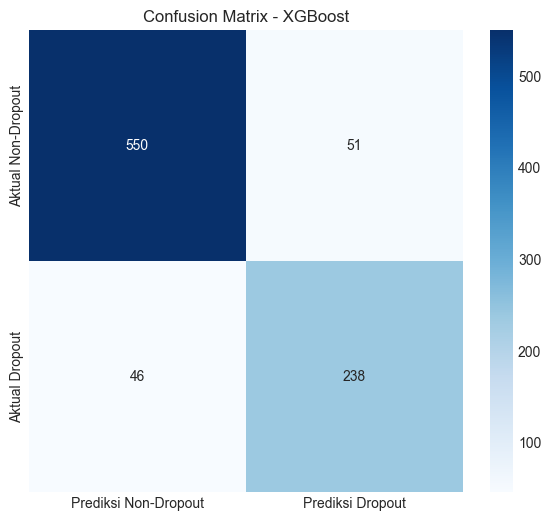


Classification Report (Test Set):
              precision    recall  f1-score   support

 Non-Dropout       0.92      0.92      0.92       601
     Dropout       0.82      0.84      0.83       284

    accuracy                           0.89       885
   macro avg       0.87      0.88      0.87       885
weighted avg       0.89      0.89      0.89       885

Accuracy (Test Set): 0.8904
Precision (Dropout) (Test Set): 0.8235
Recall (Dropout) (Test Set): 0.8380
F1-score (Dropout) (Test Set): 0.8307
ROC AUC Score (Test Set): 0.9403


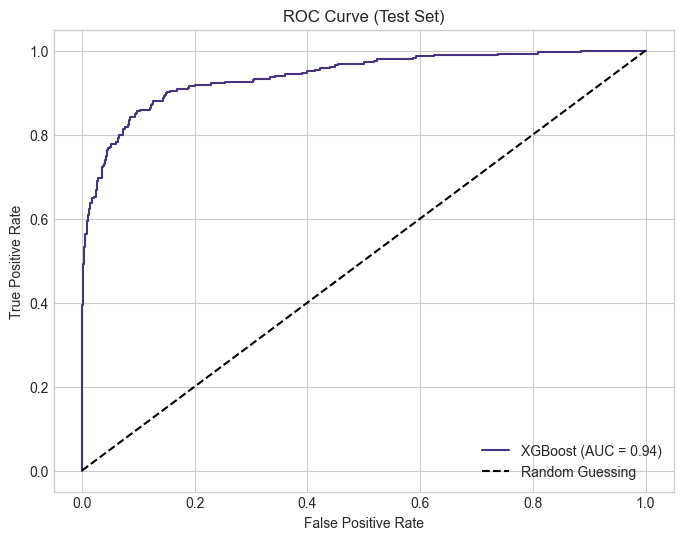

In [16]:
if final_pipeline is not None and "X_test" in locals() and "y_test" in locals():
    if "best_model_overall_name" not in locals() or best_model_overall_name is None:
        print(
            "Variabel 'best_model_overall_name' tidak ditemukan. Anda mungkin perlu menjalankan sel modeling."
        )
    if final_pipeline is not None:
        print("\n--- Evaluasi Model pada Test Set ---")
        y_pred_test = final_pipeline.predict(X_test)
        y_prob_test = final_pipeline.predict_proba(X_test)[:, 1]

        print("\nConfusion Matrix (Test Set):")
        cm_test = confusion_matrix(y_test, y_pred_test)
        print(cm_test)
        plt.figure(figsize=(7, 6))
        sns.heatmap(
            cm_test,
            annot=True,
            fmt="d",
            cmap="Blues",
            xticklabels=["Prediksi Non-Dropout", "Prediksi Dropout"],
            yticklabels=["Aktual Non-Dropout", "Aktual Dropout"],
        )
        model_name_title = (
            best_model_overall_name
            if best_model_overall_name is not None
            else "Model Final"
        )
        plt.title(f"Confusion Matrix - {model_name_title}")
        plt.show()

        print("\nClassification Report (Test Set):")
        print(
            classification_report(
                y_test, y_pred_test, target_names=["Non-Dropout", "Dropout"]
            )
        )

        print(f"Accuracy (Test Set): {accuracy_score(y_test, y_pred_test):.4f}")
        print(
            f"Precision (Dropout) (Test Set): {precision_score(y_test, y_pred_test, zero_division=0):.4f}"
        )
        print(
            f"Recall (Dropout) (Test Set): {recall_score(y_test, y_pred_test, zero_division=0):.4f}"
        )
        print(
            f"F1-score (Dropout) (Test Set): {f1_score(y_test, y_pred_test, zero_division=0):.4f}"
        )
        print(f"ROC AUC Score (Test Set): {roc_auc_score(y_test, y_prob_test):.4f}")

        fpr, tpr, _ = roc_curve(y_test, y_prob_test)
        plt.figure(figsize=(8, 6))
        plt.plot(
            fpr,
            tpr,
            label=f"{model_name_title} (AUC = {roc_auc_score(y_test, y_prob_test):.2f})",
        )
        plt.plot([0, 1], [0, 1], "k--", label="Random Guessing")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve (Test Set)")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Pipeline final tidak tersedia untuk evaluasi setelah mencoba load.")

else:
    print("Pipeline final atau data testing belum siap untuk evaluasi.")

#### Analisis Fitur Penting (Feature Importance)


Feature Importances dari model final (XGBoost):


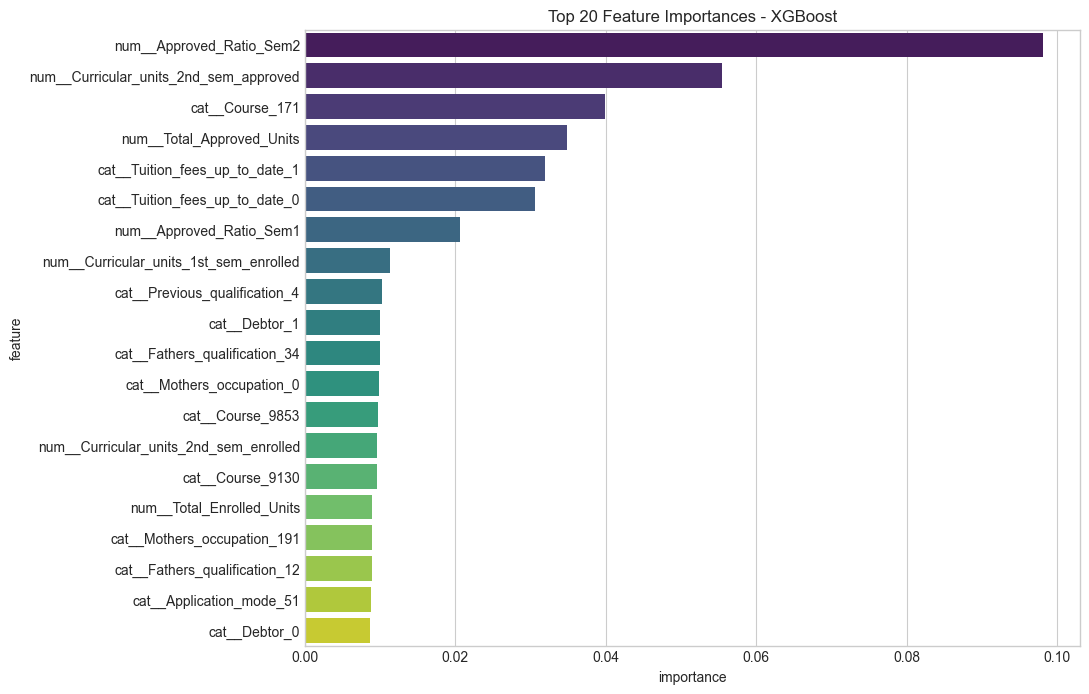

Top 10 Features:


,feature,importance
21,num__Approved_Ratio_Sem2,0.098132
12,num__Curricular_units_2nd_sem_approved,0.055515
50,cat__Course_171,0.039840
23,num__Total_Approved_Units,0.034888
240,cat__Tuition_fees_up_to_date_1,0.031985
239,cat__Tuition_fees_up_to_date_0,0.030551
20,num__Approved_Ratio_Sem1,0.020659
4,num__Curricular_units_1st_sem_enrolled,0.011362
71,cat__Previous_qualification_4,0.010193
238,cat__Debtor_1,0.010034


In [17]:
if (
    final_pipeline is not None
    and "best_model_overall_name" in locals()
    and best_model_overall_name is not None
):
    # Akses classifier di dalam pipeline
    final_classifier_step = final_pipeline.named_steps["classifier"]

    if hasattr(final_classifier_step, "feature_importances_"):
        print(f"\nFeature Importances dari model final ({best_model_overall_name}):")
        try:
            # Dapatkan nama fitur setelah preprocessing dari ColumnTransformer di dalam pipeline
            preprocessor_in_pipeline = final_pipeline.named_steps["preprocessor"]
            feature_names_processed = preprocessor_in_pipeline.get_feature_names_out()
            importances = final_classifier_step.feature_importances_

            if len(feature_names_processed) == len(importances):
                feature_importance_df = pd.DataFrame(
                    {"feature": feature_names_processed, "importance": importances}
                )
                feature_importance_df = feature_importance_df.sort_values(
                    "importance", ascending=False
                )

                plt.figure(figsize=(10, 8))
                # Tampilkan N fitur teratas, misal 20
                sns.barplot(
                    x="importance",
                    y="feature",
                    data=feature_importance_df.head(20),
                    palette="viridis",
                )
                plt.title(f"Top 20 Feature Importances - {best_model_overall_name}")
                plt.show()
                print("Top 10 Features:")
                display(feature_importance_df.head(10))
            else:
                print(
                    "Panjang nama fitur yang diproses tidak cocok dengan panjang feature importances."
                )
                print(
                    f"Nama fitur: {len(feature_names_processed)}, Importances: {len(importances)}"
                )

        except Exception as e:
            print(f"Tidak dapat mengambil nama fitur atau feature importances: {e}")
    else:
        print(
            f"Model '{best_model_overall_name}' tidak memiliki atribut 'feature_importances_'. Pertimbangkan metode lain (misal: Permutation Importance). "
        )
else:
    print(
        "Pipeline final tidak tersedia atau nama model terbaik tidak diketahui untuk analisis fitur."
    )

### Interpretasi Hasil Evaluasi Model pada Data Testing

1.  **Performa Model Secara Keseluruhan:** Model XGBoost menunjukkan performa yang sangat baik di data test, dengan ROC AUC 0.9403, Recall untuk kelas 'Dropout' sebesar 0.8380 dan F1-score 0.8307. Hasil ini konsisten atau sedikit lebih rendah dari skor validasi silang, yang mengindikasikan model tidak *overfitting* secara signifikan dan dapat generalisasi dengan baik.
2.  **Analisis Confusion Matrix:** Dari 284 mahasiswa yang sebenarnya dropout, model berhasil mengidentifikasi 238 (True Positives), namun salah mengklasifikasikan 46 sebagai non-dropout (False Negatives). Terdapat juga 51 mahasiswa non-dropout yang salah diprediksi sebagai dropout (False Positives). Fokus utama adalah meminimalkan False Negatives agar tidak ada mahasiswa berisiko tinggi yang terlewat.
3.  **Trade-off Precision vs. Recall:** Dengan Recall (Dropout) 0.8380 dan Precision (Dropout) 0.8235, model mencapai keseimbangan yang baik. Untuk institusi, Recall mungkin lebih penting untuk memastikan sebanyak mungkin mahasiswa berisiko teridentifikasi, meskipun ini bisa meningkatkan jumlah False Positives (mahasiswa yang diprediksi dropout padahal tidak). Jika sumber daya untuk intervensi terbatas, Precision juga menjadi penting.
4.  **Analisis ROC AUC:** Nilai ROC AUC 0.9403  menunjukkan kemampuan model yang sangat baik dalam membedakan antara mahasiswa yang akan dropout dan yang tidak.
5.  **Fitur Penting:** (Contoh) Fitur seperti `Appoved_Ratio_Sem2`, `Tuition_fees_up_to_date`, `Curricular_units_2nd_sem_approved`, `Scholarship_holder`, dan `Avg_Grade_Sem2` muncul sebagai fitur paling berpengaruh. Ini sejalan dengan temuan EDA bahwa status finansial dan performa akademik sangat krusial. Informasi ini bisa digunakan untuk dashboard sebagai indikator utama dan untuk merancang program intervensi yang lebih terfokus.
6.  **Kesimpulan:** Model yang dikembangkan memiliki performa yang menjanjikan untuk memprediksi potensi dropout mahasiswa dan dapat dipertimbangkan untuk implementasi awal.